# FX Volatility Project: Exploratory Data Analysis

This notebook focuses on exploring the FX data and testing for heteroskedasticity. We'll analyze the statistical properties of FX returns, identify volatility regimes, and examine the relationships between FX returns and macroeconomic factors.

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import os
import sys

# Add project directory to path
sys.path.append('..')

# Import project modules
from src.data_utils import identify_volatility_regimes
from src.visualization import (
    plot_heteroskedasticity_diagnostics,
    plot_residuals_vs_features,
    plot_volatility_regimes
)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = (14, 8)

from plot_utils import set_dark_theme
set_dark_theme()

## 1. Load Processed Data

We'll load the data that was prepared in the previous notebook.

In [39]:
# Load processed data
merged_data = pd.read_csv('../data/processed/merged_data.csv', index_col=0, parse_dates=True)
fx_returns = pd.read_csv('../data/processed/fx_returns.csv', index_col=0, parse_dates=True)
fx_volatility = pd.read_csv('../data/processed/fx_volatility.csv', index_col=0, parse_dates=True)
economic_data = pd.read_csv('../data/processed/economic_data_filled.csv', index_col=0, parse_dates=True)

# Display basic information
print(f"Merged data shape: {merged_data.shape}")
print(f"Date range: {merged_data.index.min()} to {merged_data.index.max()}")
print(f"Number of trading days: {len(merged_data)}")

Merged data shape: (3729, 100)
Date range: 2010-04-05 00:00:00 to 2025-05-30 00:00:00
Number of trading days: 3729


## 2. Statistical Properties of FX Returns

Let's analyze the statistical properties of FX returns to understand their distributions and check for stylized facts like fat tails and volatility clustering.

In [40]:
# Calculate descriptive statistics for FX returns
fx_stats = fx_returns.describe()

# Add skewness and kurtosis
fx_stats.loc['skewness'] = fx_returns.skew()
fx_stats.loc['kurtosis'] = fx_returns.kurtosis()

# Add Jarque-Bera test for normality
jb_stats = {}
jb_pvalues = {}

for col in fx_returns.columns:
    jb_stat, jb_pvalue = stats.jarque_bera(fx_returns[col].dropna())
    jb_stats[col] = jb_stat
    jb_pvalues[col] = jb_pvalue

fx_stats.loc['JB_stat'] = pd.Series(jb_stats)
fx_stats.loc['JB_pvalue'] = pd.Series(jb_pvalues)

# Display statistics
print("Statistical Properties of FX Returns:")
fx_stats

Statistical Properties of FX Returns:


,EURUSD,GBPUSD,USDJPY,AUDUSD,USDCAD,USDCHF
count,4.011000e+03,4011.000000,4011.000000,4.009000e+03,4.009000e+03,4.005000e+03
mean,-6.050096e-05,-0.000045,0.000111,-8.551361e-05,6.877319e-05,-5.578642e-05
std,5.400737e-03,0.005579,0.005835,6.719304e-03,4.778954e-03,6.302820e-03
min,-2.814408e-02,-0.079085,-0.037961,-5.456690e-02,-3.193817e-02,-1.761089e-01
25%,-3.071846e-03,-0.003022,-0.003018,-3.942422e-03,-2.584153e-03,-3.109027e-03
50%,-1.175964e-05,-0.000025,0.000216,8.947481e-05,9.699519e-05,1.396436e-04
75%,2.958313e-03,0.003077,0.003179,3.864186e-03,2.757354e-03,2.930977e-03
max,3.126232e-02,0.030308,0.037485,2.950473e-02,2.969267e-02,9.235464e-02
skewness,-4.142154e-02,-0.822154,-0.073397,-2.464897e-01,8.972954e-02,-4.789369e+00
kurtosis,2.272801e+00,12.872635,3.739516,2.638620e+00,2.372729e+00,1.652492e+02


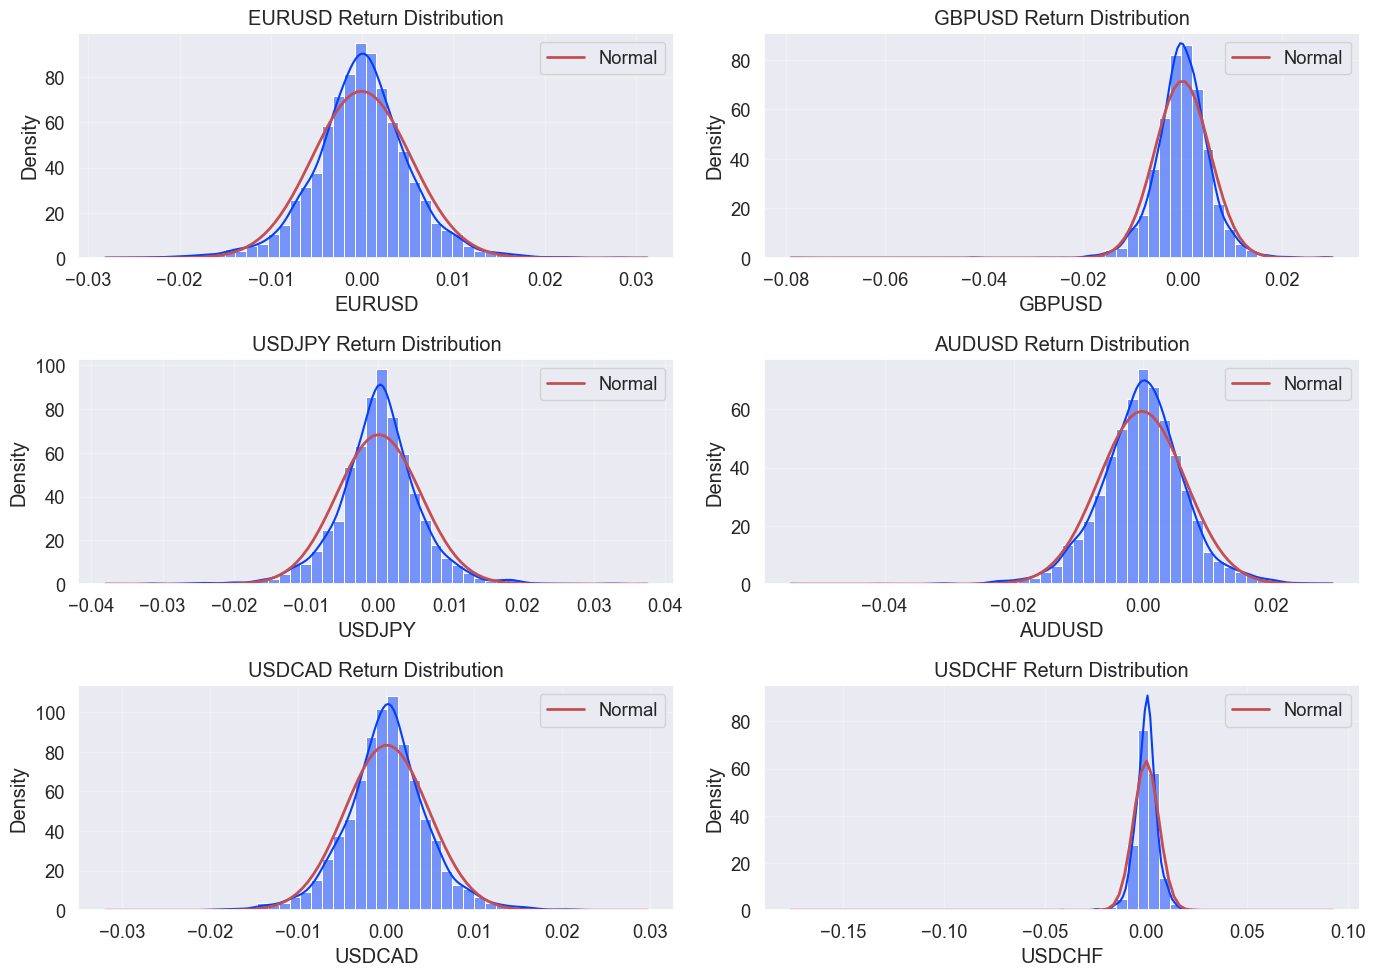

In [41]:
# Plot return distributions
plt.figure(figsize=(14, 10))

for i, pair in enumerate(fx_returns.columns):
    plt.subplot(3, 2, i+1)
    
    # Plot histogram with kernel density estimate
    sns.histplot(fx_returns[pair].dropna(), kde=True, stat='density', bins=50)
    
    # Add normal distribution for comparison
    x = np.linspace(fx_returns[pair].min(), fx_returns[pair].max(), 100)
    mean = fx_returns[pair].mean()
    std = fx_returns[pair].std()
    plt.plot(x, stats.norm.pdf(x, mean, std), 'r-', lw=2, label='Normal')
    
    plt.title(f'{pair} Return Distribution')
    plt.legend()

plt.tight_layout()
plt.show()

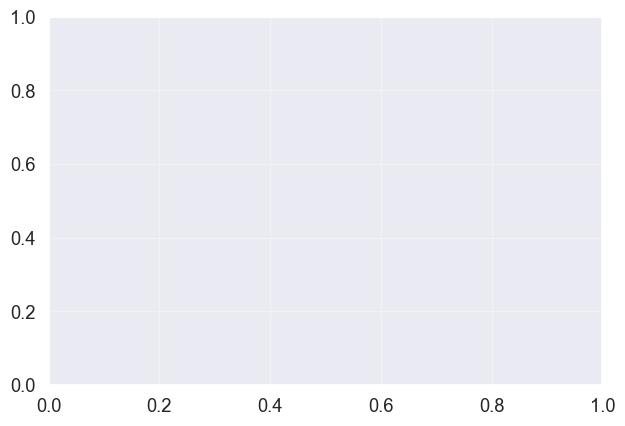

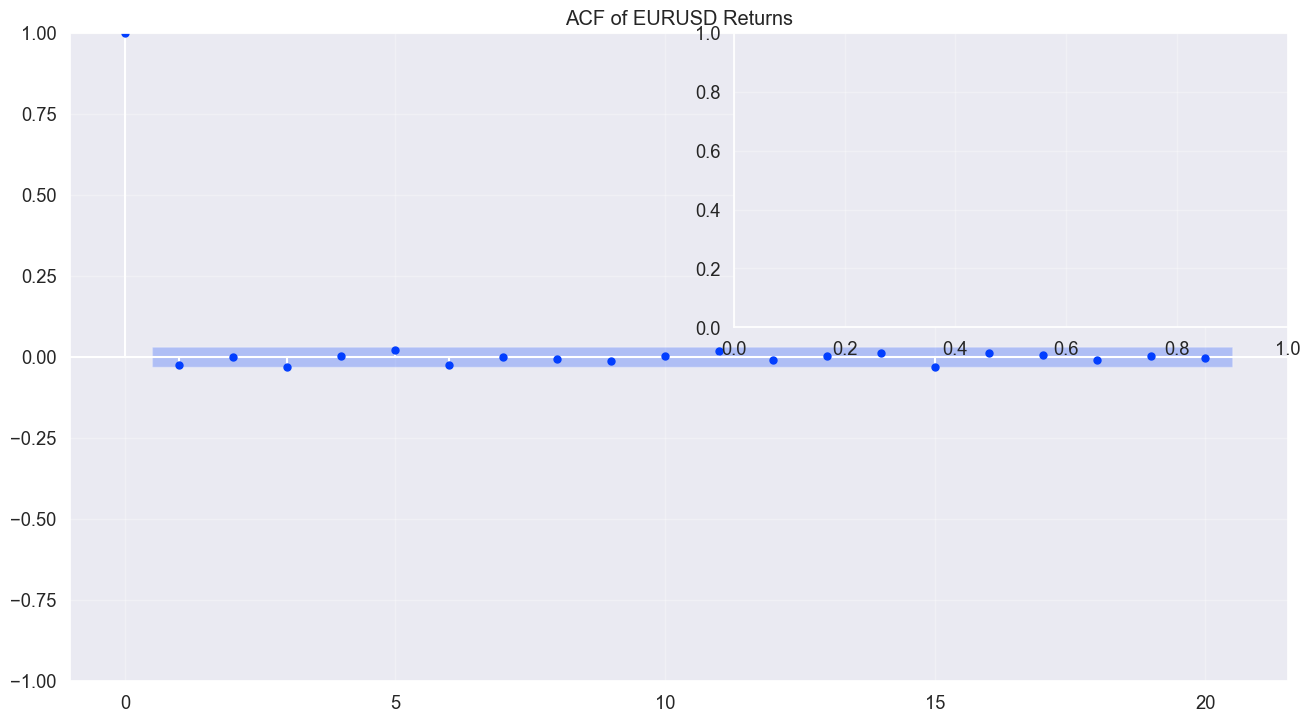

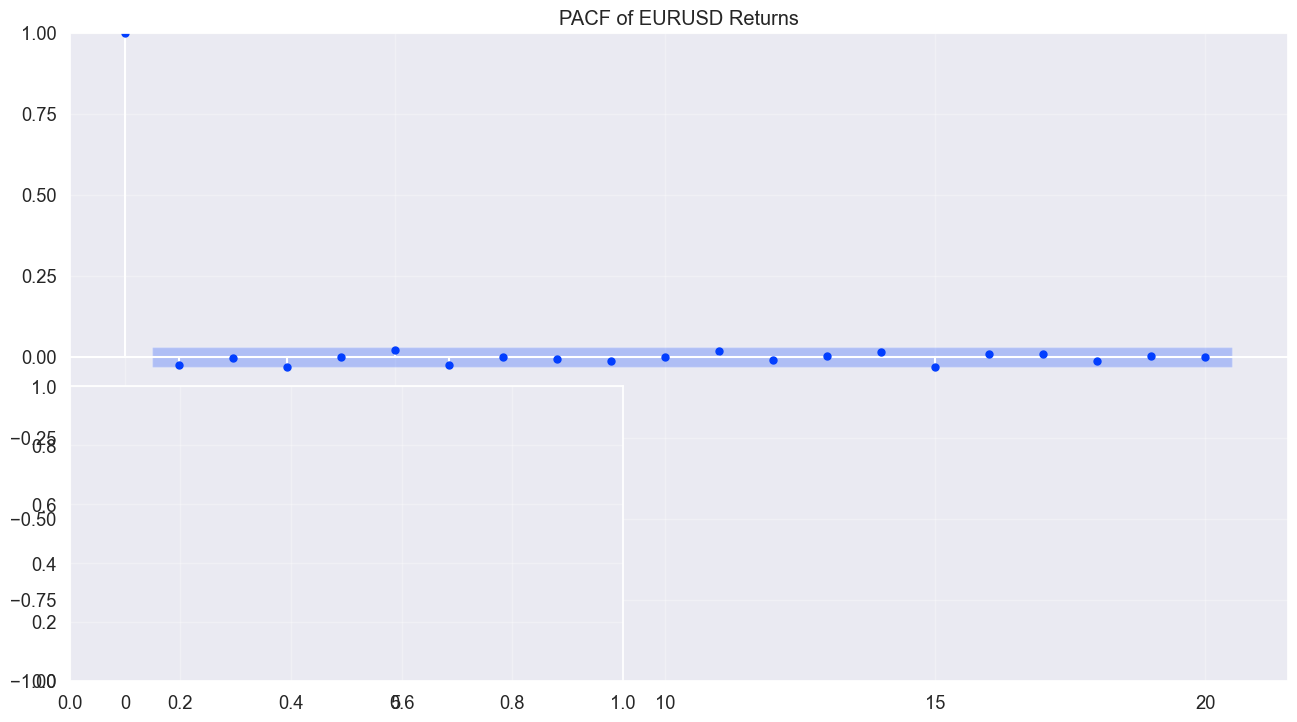

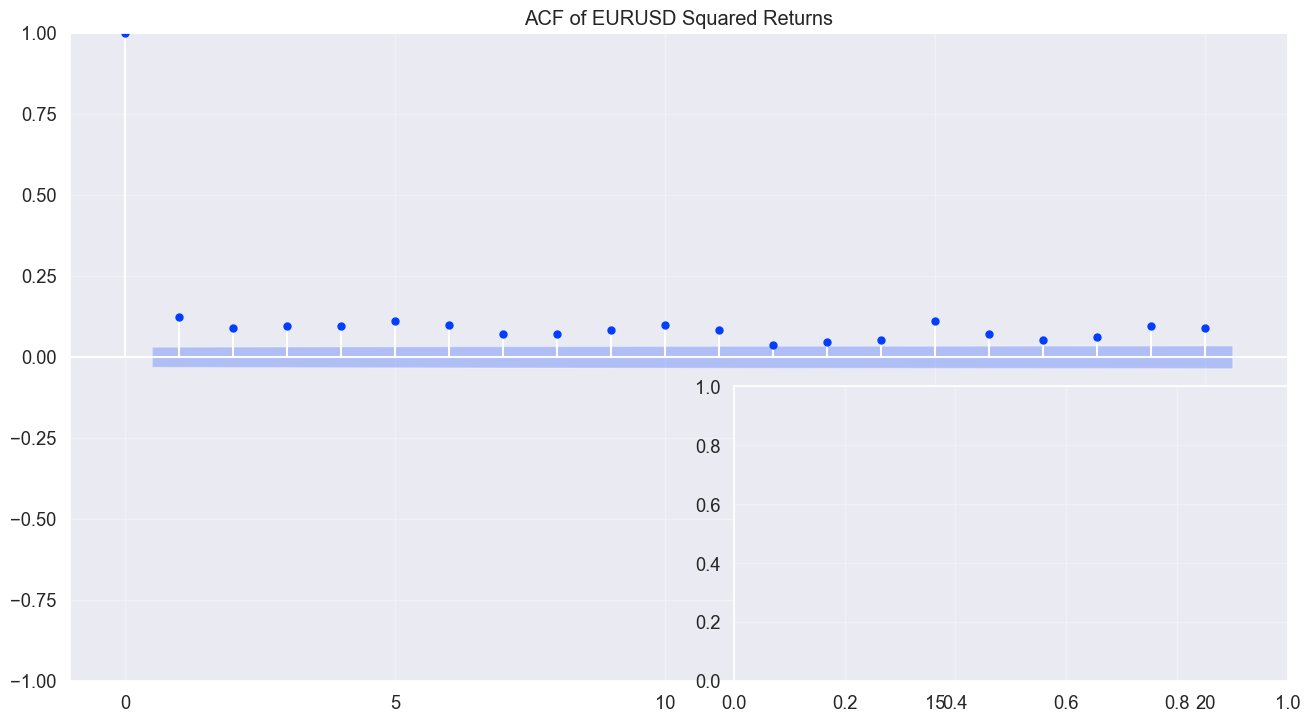

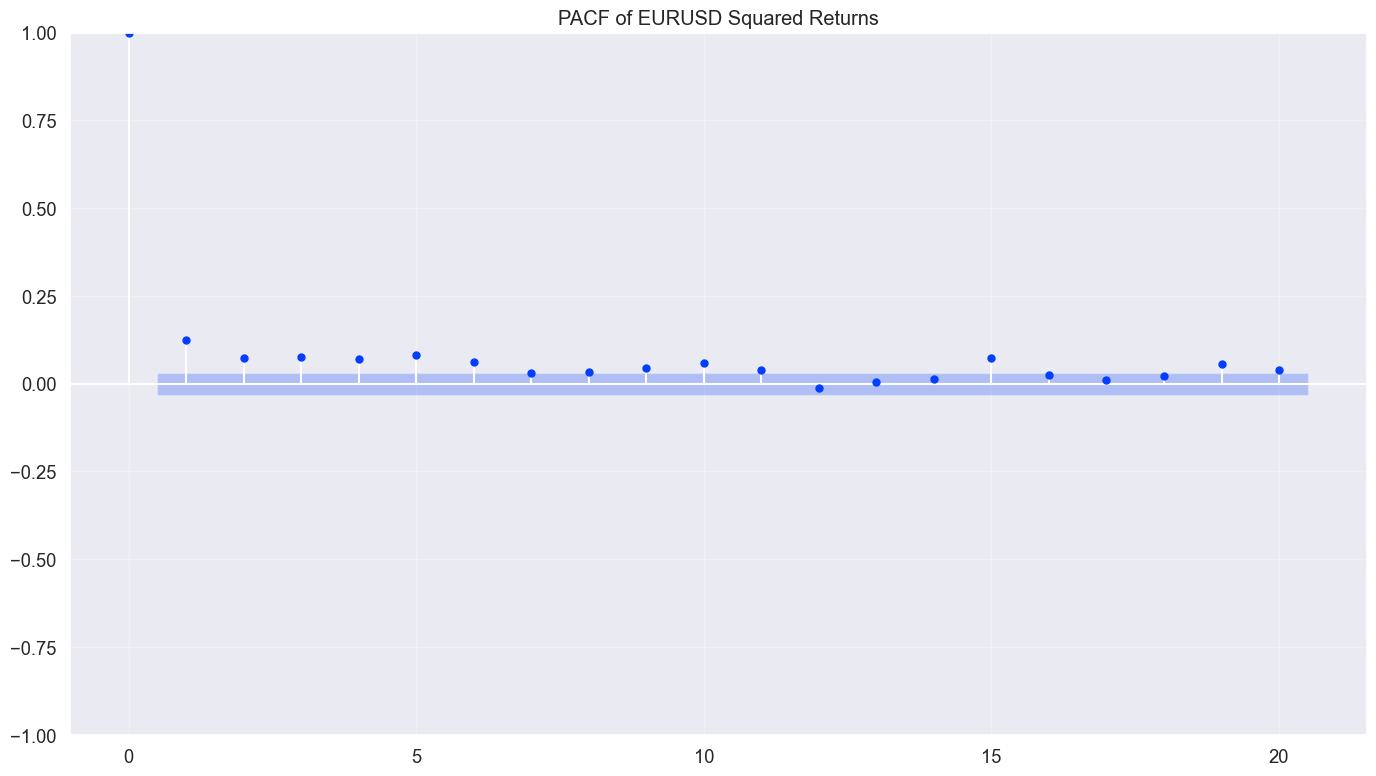

In [42]:
# Check for autocorrelation in returns and squared returns
plt.figure(figsize=(14, 10))

# Focus on EURUSD for this analysis
pair = 'EURUSD'

# ACF of returns
plt.subplot(2, 2, 1)
plot_acf(fx_returns[pair].dropna(), lags=20, title=f'ACF of {pair} Returns')

# PACF of returns
plt.subplot(2, 2, 2)
plot_pacf(fx_returns[pair].dropna(), lags=20, title=f'PACF of {pair} Returns')

# ACF of squared returns (volatility clustering)
plt.subplot(2, 2, 3)
plot_acf(fx_returns[pair].dropna()**2, lags=20, title=f'ACF of {pair} Squared Returns')

# PACF of squared returns
plt.subplot(2, 2, 4)
plot_pacf(fx_returns[pair].dropna()**2, lags=20, title=f'PACF of {pair} Squared Returns')

plt.tight_layout()
plt.show()

## 3. Volatility Regime Identification

Now we'll identify different volatility regimes in the FX market using clustering techniques.

/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


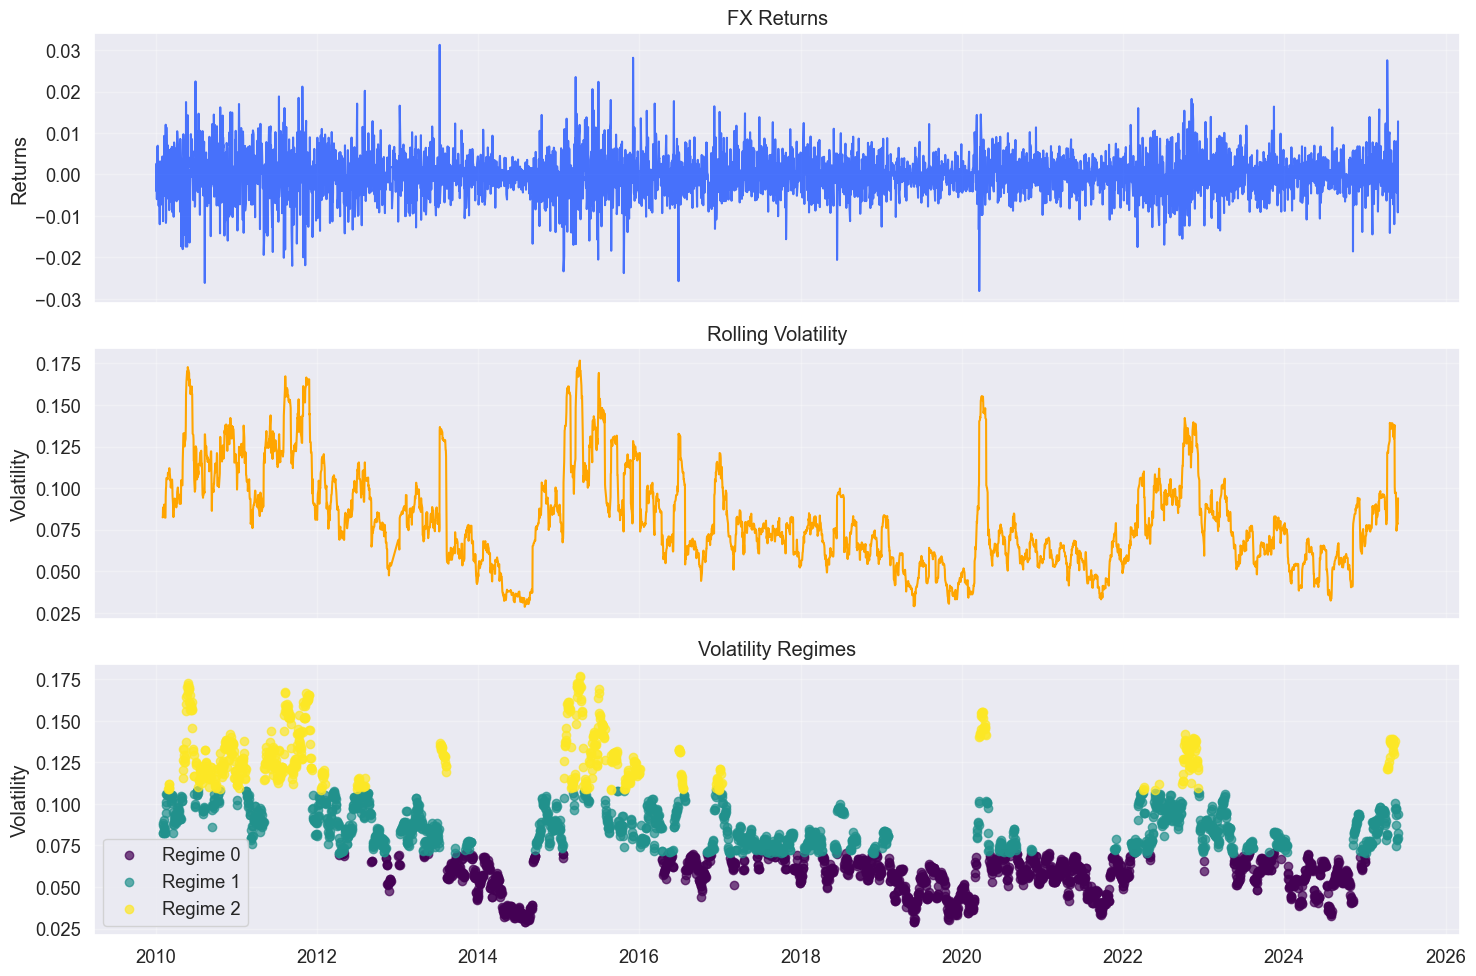

In [43]:
# Identify volatility regimes for EURUSD
pair = 'EURUSD'
vol_column = f'{pair}_vol_22d'  # 22-day rolling volatility

# Identify regimes using k-means clustering
regimes_data = identify_volatility_regimes(
    fx_returns, 
    pair, 
    n_regimes=3,  # Low, medium, high volatility
    window=22
)

# Plot volatility regimes
fig = plot_volatility_regimes(
    fx_returns[pair], 
    regimes_data['volatility'], 
    regimes_data['regime']
)

# Save the figure
os.makedirs('../results/figures', exist_ok=True)
fig.savefig('../results/figures/volatility_regimes.png', dpi=300, bbox_inches='tight')

In [44]:
# Analyze regime statistics
regime_stats = regimes_data.groupby('regime').agg({
    'volatility': ['mean', 'std', 'min', 'max', 'count']
})

# Calculate percentage of time in each regime
regime_stats['percentage'] = regime_stats[('volatility', 'count')] / len(regimes_data) * 100

print("Volatility Regime Statistics:")
regime_stats

Volatility Regime Statistics:


volatility                                     percentage
             mean       std       min       max count           
regime                                                          
0        0.055280  0.010386  0.028625  0.070448  1672  42.126480
1        0.085915  0.010380  0.070465  0.108171  1598  40.262031
2        0.130728  0.016118  0.108217  0.176706   699  17.611489

In [45]:
# Analyze return characteristics in different regimes
# Merge regimes with returns
regimes_with_returns = pd.DataFrame({
    'returns': fx_returns[pair][regimes_data.index],
    'regime': regimes_data['regime']
})

# # Calculate return statistics by regime
# return_stats_by_regime = regimes_with_returns.groupby('regime').agg({
#     'returns': ['mean', 'std', 'skew', 'kurt', 'min', 'max']
# })


# Import scipy.stats if not already imported
from scipy import stats

# Calculate return statistics by regime
return_stats_by_regime = regimes_with_returns.groupby('regime').agg({
    'returns': ['mean', 'std', 'skew', lambda x: stats.kurtosis(x), 'min', 'max']
})

# Rename the lambda function column
return_stats_by_regime.columns = ['mean', 'std', 'skew', 'kurt', 'min', 'max']

print("Return Statistics by Volatility Regime:")
return_stats_by_regime

Return Statistics by Volatility Regime:


,mean,std,skew,kurt,min,max
regime,,,,,,
0,-0.000025,0.003537,-0.031029,0.560386,-0.016732,0.012148
1,-0.000045,0.005485,-0.082156,0.476080,-0.023396,0.017686
2,-0.000147,0.008219,0.021649,0.763899,-0.028144,0.031262


## 4. Initial OLS Regression and Heteroskedasticity Testing

Let's run an initial OLS regression to model FX returns and test for heteroskedasticity.

In [46]:
# Prepare data for regression
# We'll model EURUSD returns using lagged variables and economic indicators
target_pair = 'EURUSD'

# Select features
features = [
    f'{target_pair}_lag1',
    f'{target_pair}_lag2',
    'DGS10',
    'VIXCLS',
    'DTWEXBGS',
    'US_EU_RATE_DIFF'
]

# Prepare X and y
y = merged_data[target_pair]
X = merged_data[features]

# Add constant
X = sm.add_constant(X)

# Run OLS regression
ols_model = sm.OLS(y, X).fit()

# Display results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 EURUSD   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9787
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.429
Time:                        07:21:56   Log-Likelihood:                 14214.
No. Observations:                3729   AIC:                        -2.842e+04
Df Residuals:                    3723   BIC:                        -2.838e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0002      0.001     

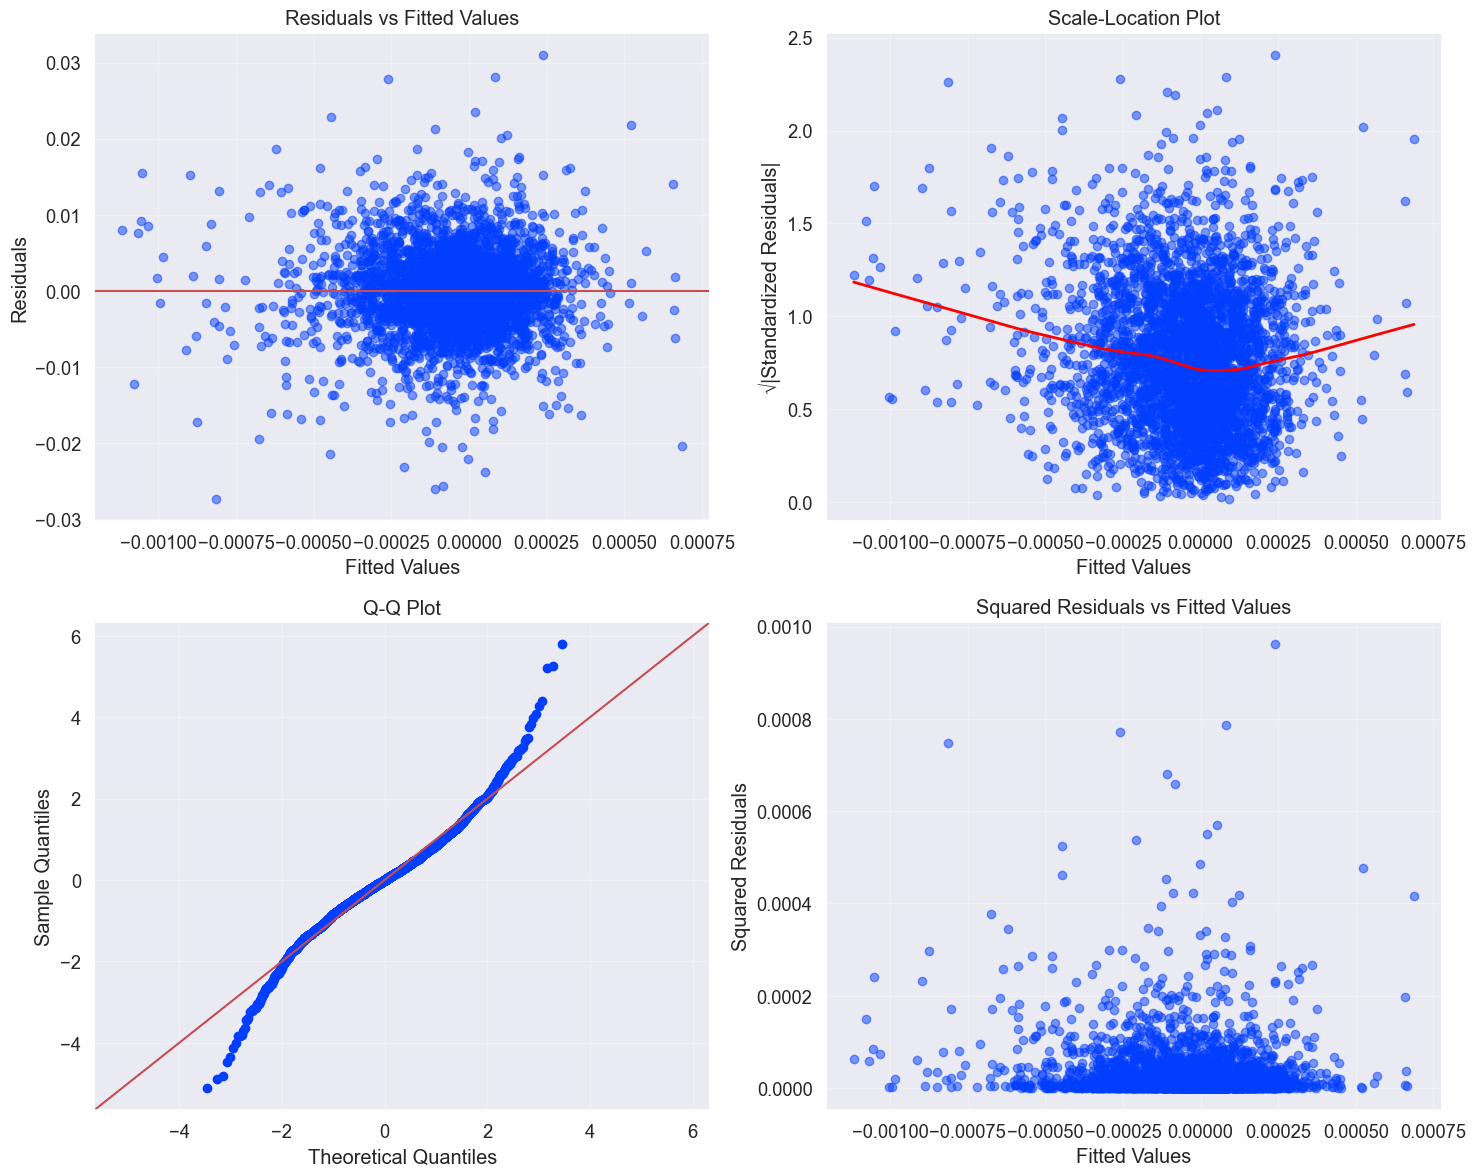

In [47]:
# Extract residuals and fitted values
residuals = ols_model.resid
fitted_values = ols_model.fittedvalues

# Create diagnostic plots for heteroskedasticity
fig = plot_heteroskedasticity_diagnostics(ols_model, X.values, features)

# Save the figure
fig.savefig('../results/figures/heteroskedasticity_diagnostics.png', dpi=300, bbox_inches='tight')

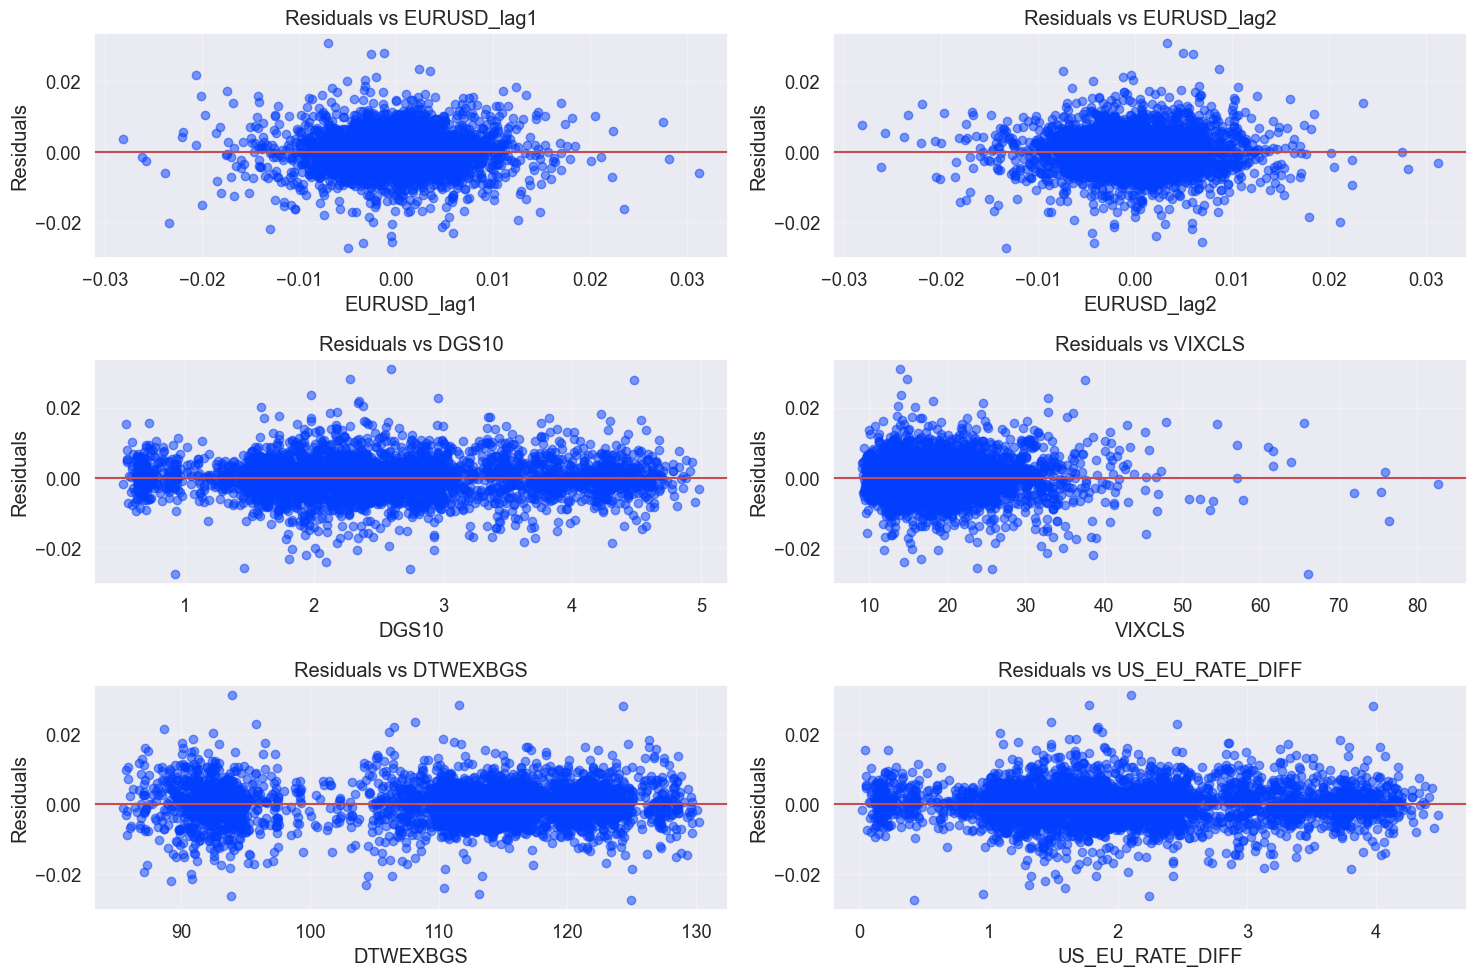

In [48]:
# Plot residuals against each feature
fig = plot_residuals_vs_features(ols_model, X.values[:, 1:], features)

# Save the figure
fig.savefig('../results/figures/residuals_vs_features.png', dpi=300, bbox_inches='tight')

In [49]:
# Formal tests for heteroskedasticity

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X)
bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_results = dict(zip(bp_labels, bp_test))

print("Breusch-Pagan test for heteroskedasticity:")
for key, value in bp_results.items():
    print(f"{key}: {value:.4f}")

if bp_results['LM-Test p-value'] < 0.05:
    print("Reject null hypothesis - heteroskedasticity is present")
else:
    print("Fail to reject null hypothesis - no evidence of heteroskedasticity")

# White test
white_test = het_white(residuals, X)
white_results = dict(zip(bp_labels, white_test))

print("\nWhite's test for heteroskedasticity:")
for key, value in white_results.items():
    print(f"{key}: {value:.4f}")

if white_results['LM-Test p-value'] < 0.05:
    print("Reject null hypothesis - heteroskedasticity is present")
else:
    print("Fail to reject null hypothesis - no evidence of heteroskedasticity")

Breusch-Pagan test for heteroskedasticity:
LM Statistic: 195.7393
LM-Test p-value: 0.0000
F-Statistic: 41.2501
F-Test p-value: 0.0000
Reject null hypothesis - heteroskedasticity is present

White's test for heteroskedasticity:
LM Statistic: 289.5265
LM-Test p-value: 0.0000
F-Statistic: 15.6065
F-Test p-value: 0.0000
Reject null hypothesis - heteroskedasticity is present


## 5. Relationship Between Volatility and Prediction Errors

Let's examine how prediction errors vary with volatility levels.

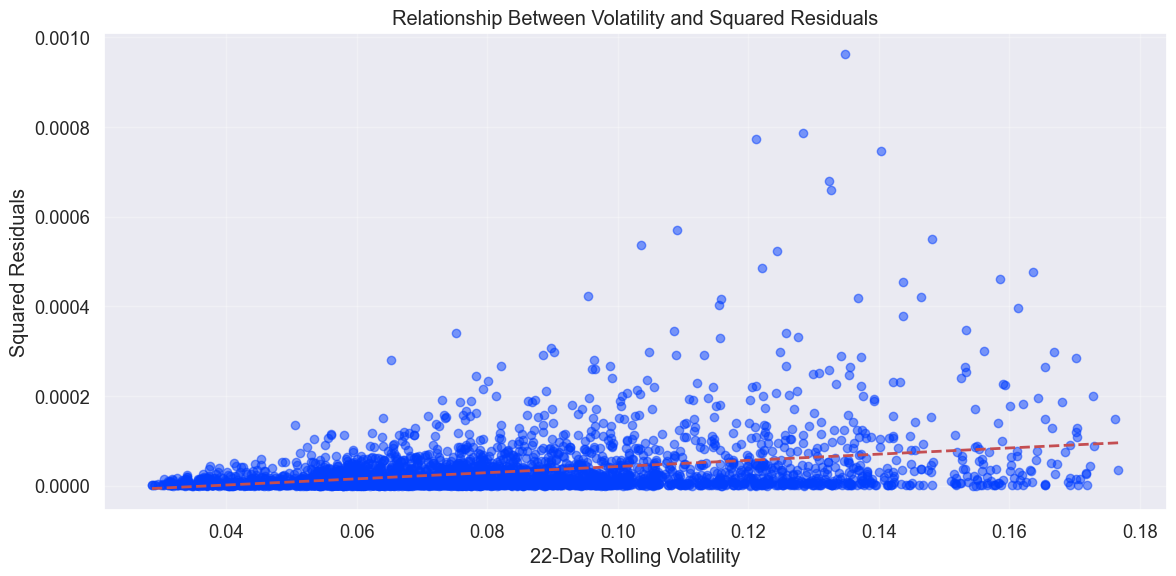

In [50]:
# Create a DataFrame with residuals, fitted values, and volatility
analysis_df = pd.DataFrame({
    'residuals': residuals,
    'abs_residuals': np.abs(residuals),
    'squared_residuals': residuals**2,
    'fitted_values': fitted_values,
    'volatility': merged_data[f'{target_pair}_vol_22d']
})

# Plot relationship between volatility and squared residuals
plt.figure(figsize=(12, 6))

plt.scatter(analysis_df['volatility'], analysis_df['squared_residuals'], alpha=0.5)
plt.xlabel('22-Day Rolling Volatility')
plt.ylabel('Squared Residuals')
plt.title('Relationship Between Volatility and Squared Residuals')

# Add trend line
z = np.polyfit(analysis_df['volatility'].dropna(), analysis_df['squared_residuals'].dropna(), 1)
p = np.poly1d(z)
plt.plot(analysis_df['volatility'].sort_values(), p(analysis_df['volatility'].sort_values()), 'r--', linewidth=2)

plt.tight_layout()
plt.savefig('../results/figures/volatility_vs_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
# Estimate variance function
log_squared_resid = np.log(residuals**2)

# Model 1: Variance as a function of volatility
X_vol = sm.add_constant(merged_data[f'{target_pair}_vol_22d'])
var_model_vol = sm.OLS(log_squared_resid, X_vol).fit()

# Model 2: Variance as a function of VIX
X_vix = sm.add_constant(merged_data['VIXCLS'])
var_model_vix = sm.OLS(log_squared_resid, X_vix).fit()

# Model 3: Variance as a function of multiple predictors
X_multi = sm.add_constant(merged_data[[f'{target_pair}_vol_22d', 'VIXCLS', 'DTWEXBGS']])
var_model_multi = sm.OLS(log_squared_resid, X_multi).fit()

# Compare models
print("Variance Model 1 (Volatility):\n")
print(var_model_vol.summary().tables[1])
print(f"R-squared: {var_model_vol.rsquared:.4f}\n")

print("Variance Model 2 (VIX):\n")
print(var_model_vix.summary().tables[1])
print(f"R-squared: {var_model_vix.rsquared:.4f}\n")

print("Variance Model 3 (Multiple Predictors):\n")
print(var_model_multi.summary().tables[1])
print(f"R-squared: {var_model_multi.rsquared:.4f}")

Variance Model 1 (Volatility):

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -13.8782      0.107   -129.810      0.000     -14.088     -13.669
EURUSD_vol_22d    22.7258      1.254     18.117      0.000      20.266      25.185
R-squared: 0.0809

Variance Model 2 (VIX):

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9486      0.106   -122.368      0.000     -13.156     -12.741
VIXCLS         0.0480      0.005      8.994      0.000       0.038       0.058
R-squared: 0.0212

Variance Model 3 (Multiple Predictors):

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -14.1012      0.406    -34.692   

## 6. Correlation Analysis

Let's examine the correlations between FX returns and macroeconomic factors across different volatility regimes.

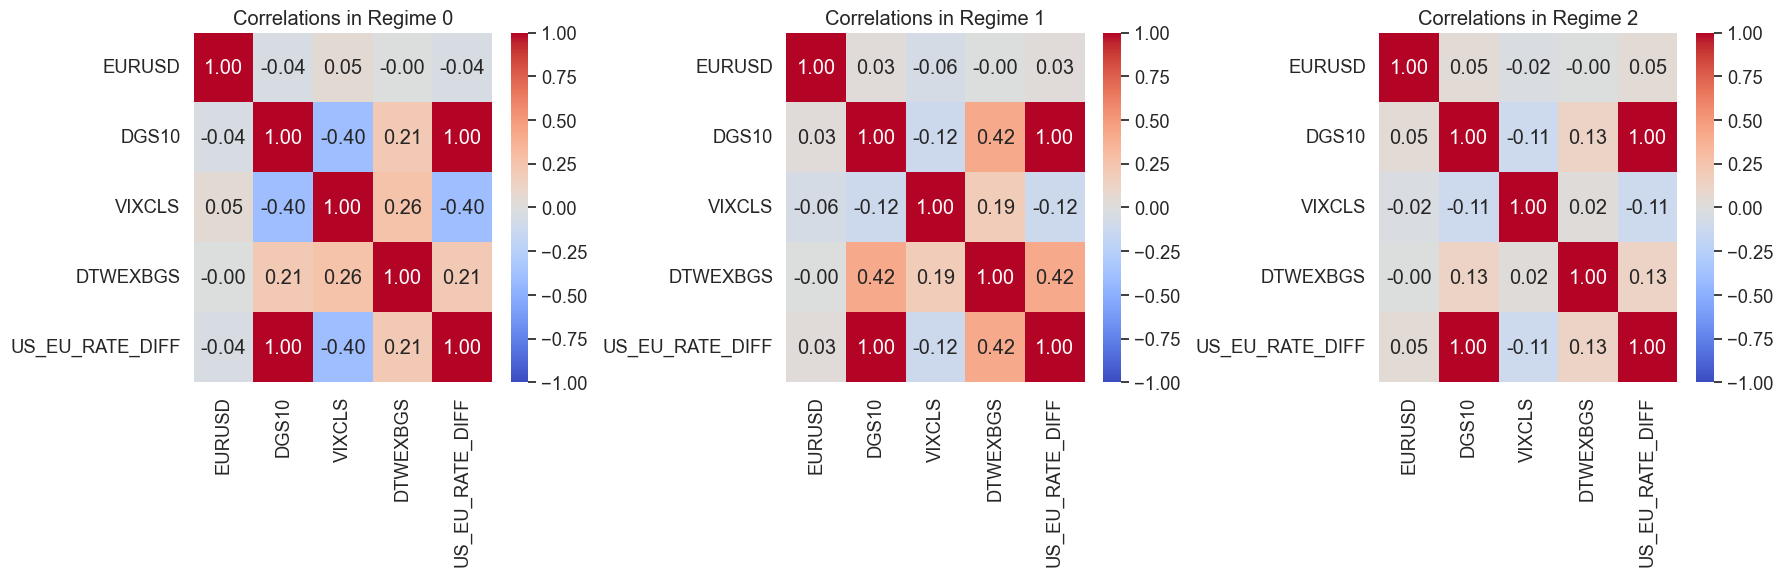

In [52]:
# Merge regimes with merged_data
merged_with_regimes = merged_data.copy()
merged_with_regimes['regime'] = regimes_data['regime']

# Calculate correlations for each regime
correlations = {}
for regime in sorted(merged_with_regimes['regime'].unique()):
    regime_data = merged_with_regimes[merged_with_regimes['regime'] == regime]
    
    # Select relevant columns for correlation analysis
    cols_to_analyze = [target_pair, 'DGS10', 'VIXCLS', 'DTWEXBGS', 'US_EU_RATE_DIFF']
    
    # Calculate correlation matrix
    corr_matrix = regime_data[cols_to_analyze].corr()
    correlations[f'Regime {regime}'] = corr_matrix

# Plot correlation heatmaps for each regime
fig, axes = plt.subplots(1, len(correlations), figsize=(18, 6))

for i, (regime_name, corr_matrix) in enumerate(correlations.items()):
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i], fmt='.2f')
    axes[i].set_title(f'Correlations in {regime_name}')

plt.tight_layout()
plt.savefig('../results/figures/regime_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Summary of Findings

Based on our exploratory analysis, we can summarize the following findings:

In [53]:
# Create a summary of findings
findings = {
    'Return Distribution': 'FX returns exhibit non-normal distributions with excess kurtosis (fat tails) and slight skewness.',
    'Volatility Clustering': 'Strong evidence of volatility clustering in FX returns, as shown by significant autocorrelation in squared returns.',
    'Heteroskedasticity': f'Both Breusch-Pagan (p={bp_results["LM-Test p-value"]:.4f}) and White tests (p={white_results["LM-Test p-value"]:.4f}) confirm the presence of heteroskedasticity.',
    'Volatility Regimes': f'Identified {len(regimes_data["regime"].unique())} distinct volatility regimes in the FX market.',
    'Variance Function': 'The variance of prediction errors is strongly related to market volatility and VIX index.',
    'Regime-Dependent Correlations': 'Correlations between FX returns and economic factors vary across different volatility regimes.'
}

# Display findings
print("Summary of Findings:")
for key, value in findings.items():
    print(f"\n{key}:\n{value}")

Summary of Findings:

Return Distribution:
FX returns exhibit non-normal distributions with excess kurtosis (fat tails) and slight skewness.

Volatility Clustering:
Strong evidence of volatility clustering in FX returns, as shown by significant autocorrelation in squared returns.

Heteroskedasticity:
Both Breusch-Pagan (p=0.0000) and White tests (p=0.0000) confirm the presence of heteroskedasticity.

Volatility Regimes:
Identified 3 distinct volatility regimes in the FX market.

Variance Function:
The variance of prediction errors is strongly related to market volatility and VIX index.

Regime-Dependent Correlations:
Correlations between FX returns and economic factors vary across different volatility regimes.


## 8. Implications for Modeling

Based on our findings, we can draw the following implications for our modeling approach:

1. **Need for Weighted Least Squares**: The clear presence of heteroskedasticity in FX returns suggests that OLS regression will be inefficient. Weighted Least Squares regression should provide more reliable coefficient estimates and standard errors.

2. **Variance Function Specification**: Our analysis suggests that the variance function for WLS should incorporate both market volatility measures and the VIX index, as both are significant predictors of error variance.

3. **Regime-Specific Modeling**: The identification of distinct volatility regimes and the varying correlations across these regimes suggest that we might benefit from regime-specific models or a regime-switching approach.

4. **Position Sizing Strategy**: For trading applications, position sizes should be adjusted inversely to volatility to maintain consistent risk levels across different market regimes.

5. **Feature Selection**: The correlation analysis across regimes can guide our feature selection for the regression models, focusing on variables that maintain consistent relationships with FX returns.

In the next notebook, we will implement both OLS and WLS regression models and compare their performance.

In [54]:
# Save key results for use in subsequent notebooks
os.makedirs('../results/models', exist_ok=True)

# Save regimes data
regimes_data.to_csv('../results/models/volatility_regimes.csv')

# Save variance model
import pickle
with open('../results/models/variance_model.pkl', 'wb') as f:
    pickle.dump(var_model_multi, f)

print("Results saved for use in subsequent notebooks.")

Results saved for use in subsequent notebooks.
